#Machine Learning Enhanced Pairs Trading

In [ ]:
!pip install darts

In [2]:
# Importing the necessary libraries
import os
import math
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries
from darts.models import NHiTSModel, NBEATSModel, TCNModel, TransformerModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mse, mape, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention, Dense, Dropout, Bidirectional, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras import backend as K

In [3]:
INPUT_CHUNK_LENGTH = 50
OUTPUT_CHUNK_LENGTH = 1
N_EPOCHS = 50
BATCH_SIZE = 1024

#Data Processor: CSV Parsing Tool

In [4]:
class DataProcessor:
    def __init__(self, file_path='/content/bbdc3_4_min.csv'):
        self.file_path = file_path
        self.data_df = None

    def load_and_prepare_data(self):
        """Loads the CSV file and calculates the ratio if not already done."""
        if self.data_df is None:
            self.data_df = pd.read_csv(self.file_path)
            numerator_column_name = self.data_df.columns[2]
            denominator_column_name = self.data_df.columns[1]
            self.data_df['ratio'] = self.data_df[numerator_column_name] / self.data_df[denominator_column_name]
        return self.data_df

    def get_ratio_time_series(self):
        """Converts the ratio column to a time series object."""
        """Compatible with the Darts library."""
        df = self.load_and_prepare_data()
        return TimeSeries.from_dataframe(df, value_cols='ratio')

    def get_test_columns(self, test_size):
        """Retrieves the test dataset's numerator and denominator columns."""
        self.load_and_prepare_data()
        numerator_column_name = self.data_df.columns[2]
        denominator_column_name = self.data_df.columns[1]
        return (self.data_df[numerator_column_name].values)[-test_size:], (self.data_df[denominator_column_name].values)[-test_size:]

    def plot_ratio(self):
        """Plots the ratio time series."""
        df = self.load_and_calculate_ratio()
        numerator = df.columns[2]
        denominator = df.columns[1]
        plt.title(f'Ratio of {numerator} to {denominator}', color='red')
        plt.plot(df['ratio'], color='blue', label="Ratio")
        plt.xlabel('Observation')
        plt.ylabel('Ratio Value')
        plt.legend()
        plt.show()

#Financial Forecasting Model

In [5]:
class FinancialForecastingModel:
    def __init__(self, model, data_processor):
        self.model = model
        self.data_processor = data_processor
        self.scaler_darts = None
        self.scaler_tf = None

    def split_and_scale_data_tf(self, train_ratio=0.5, validation_ratio=0.1):
        """Splits the data into training, validation, and test sets and applies scaling."""
        """Compatible with the TensorFlow library."""
        series = self.data_processor.load_and_prepare_data()
        series = series['ratio'].values
        series = series.reshape(-1, 1)

        num_observations = len(series)
        train_end_index = int(num_observations * train_ratio)
        validation_end_index = int(num_observations * (train_ratio + validation_ratio))

        train_data = series[:train_end_index]
        valid_data = series[train_end_index:validation_end_index]
        test_data = series[validation_end_index:]

        self.scaler_tf = MinMaxScaler((0, 1))
        train_data = self.scaler_tf.fit_transform(train_data)
        valid_data = self.scaler_tf.transform(valid_data)
        test_data = self.scaler_tf.transform(test_data)

        X_train = []
        y_train = []
        X_valid = []
        y_valid = []
        X_test = []
        y_test = []

        for i in range(INPUT_CHUNK_LENGTH, len(train_data)):
            X_train.append(train_data[i - INPUT_CHUNK_LENGTH : i])
            y_train.append(train_data[i + (OUTPUT_CHUNK_LENGTH - 1)])

        for i in range(INPUT_CHUNK_LENGTH, len(valid_data)):
            X_valid.append(valid_data[i - INPUT_CHUNK_LENGTH : i])
            y_valid.append(valid_data[i + (OUTPUT_CHUNK_LENGTH - 1)])

        for i in range(INPUT_CHUNK_LENGTH, len(test_data)):
            X_test.append(test_data[i - INPUT_CHUNK_LENGTH : i])
            y_test.append(test_data[i + (OUTPUT_CHUNK_LENGTH - 1)])

        X_train, y_train = np.array(X_train), np.array(y_train)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_train, y_train = shuffle(X_train, y_train)

        X_valid, y_valid = np.array(X_valid), np.array(y_valid)
        X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

        X_test, y_test = np.array(X_test), np.array(y_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        return {'x_train': X_train, 'y_train': y_train, 'x_valid': X_valid, 'y_valid': y_valid, 'x_test': X_test, 'y_test': y_test}

    def split_and_scale_data_darts(self, train_ratio=0.5, validation_ratio=0.1):
        """Splits the data into training, validation, and test sets and applies scaling."""
        """Compatible with the Darts library."""
        series = self.data_processor.get_ratio_time_series()

        num_observations = len(series)
        train_end_index = int(num_observations * train_ratio)
        validation_end_index = int(num_observations * (train_ratio + validation_ratio))

        train_series = series[:train_end_index]
        val_series = series[train_end_index:validation_end_index]
        test_series = series[validation_end_index:]

        # Scaling the data
        self.scaler_darts = Scaler()
        train_series_scaled = self.scaler_darts.fit_transform(train_series)
        valid_series_scaled = self.scaler_darts.transform(val_series)
        test_series_scaled = self.scaler_darts.transform(test_series)

        return train_series_scaled, valid_series_scaled, test_series_scaled

    def train_darts(self, train_series, validation_series):
        """Trains the model."""
        """Compatible with the Darts library."""
        self.model.fit(train_series, val_series=validation_series, verbose=True)

    def train_tf(self, x_train, y_train, x_valid, y_valid):
        """Trains the model."""
        """Compatible with the TensorFlow library."""
        self.model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(x_valid, y_valid))

    def predict_future_values_darts(self, test_series):
        """Makes future value predictions based on the test series."""
        """Compatible with the Darts library."""
        return self.model.predict(OUTPUT_CHUNK_LENGTH, series=test_series)

    def predict_future_values_tf(self, x_test):
        """Makes future value predictions based on the test series."""
        """Compatible with the TensorFlow library."""
        return self.model.predict(x_test)

    def generate_predictions_darts(self, test_series):
        """Generates predictions for each window of the test series."""
        """Compatible with the Darts library."""
        transformed_series = []

        for i in range(len(test_series) - INPUT_CHUNK_LENGTH):
            transformed_series.append(test_series[i: i + INPUT_CHUNK_LENGTH])

        pred_series = self.predict_future_values_darts(transformed_series)

        predicted_values = []
        for pred in pred_series:
            predicted_values.append(pred.values()[0][0])

        predicted_df = pd.DataFrame(predicted_values, columns=['predicted'])
        tseries_predicted = TimeSeries.from_dataframe(predicted_df, value_cols='predicted')
        tseries_predicted = self.scaler_darts.inverse_transform(tseries_predicted).pd_series(copy=True)
        predicted_values = tseries_predicted.values.tolist()

        return predicted_values

    def generate_predictions_tf(self, x_test, y_test):
        """Generates predictions for each window of the test series."""
        """Compatible with the TensorFlow library."""
        pred_series = self.predict_future_values_tf(x_test)
        pred_series = self.scaler_tf.inverse_transform(pred_series)

        # Storing the predictions
        predicted_values = pred_series.tolist()
        true_values = self.scaler_tf.inverse_transform(y_test).tolist()
        return {'predicted_values': predicted_values, 'true_values': true_values}

    def get_true_values_darts(self, test_series):
        """Retrieves true values from the test series after scaling back."""
        """Compatible with the Darts library."""
        test_series_inverse = self.scaler_darts.inverse_transform(test_series)
        true_df = test_series_inverse.pd_series(copy=True)
        true_values = true_df[INPUT_CHUNK_LENGTH:].values.tolist()
        return true_values

    def calculate_smape(self, actual, predicted):
        """Calculates the Symmetric Mean Absolute Percentage Error (SMAPE)."""
        actual, predicted = np.asarray(actual), np.asarray(predicted)
        denominator = (np.abs(actual) + np.abs(predicted)) / 2.0
        diff = np.abs(actual - predicted) / denominator
        diff[denominator == 0] = 0.0  # avoid division by zero
        return 100 * np.mean(diff)

    def calculate_mape(self, actual, predicted):
        """Calculates the Mean Absolute Percentage Error (MAPE)."""
        actual, predicted = np.asarray(actual), np.asarray(predicted)
        diff = np.abs((actual - predicted) / actual)
        diff[actual == 0] = 0.0  # avoid division by zero
        return 100 * np.mean(diff)

    def calculate_mase(self, actual, predicted):
        """Calculates the Mean Absolute Scaled Error (MASE)."""
        actual, predicted = np.asarray(actual), np.asarray(predicted)
        n = len(actual)
        d = np.abs(np.diff(actual)).sum() / (n - 1)
        errors = np.abs(actual - predicted)
        return errors.mean() / d

    def calculate_rmse(self, actual, predicted):
        """Calculates the Root Mean Squared Error (RMSE)."""
        actual, predicted = np.asarray(actual), np.asarray(predicted)
        return np.sqrt(((predicted - actual) ** 2).mean())

    def calculate_prediction_error(self, predicted_values, true_values):
        """Calculates the prediction error."""
        smape = self.calculate_smape(predicted_values, true_values)
        mape = self.calculate_mape(predicted_values, true_values)
        mase = self.calculate_mase(predicted_values, true_values)
        rmse = self.calculate_rmse(predicted_values, true_values)
        return {'RMSE': rmse, 'MASE': mase, 'MAPE': mape, 'sMAPE': smape}

#Confusion Matrix

In [6]:
class ConfusionMatrix():
    def __init__(self):
        self.true_positive = 0
        self.false_positive = 0
        self.false_negative = 0
        self.true_negative = 0

    def update(self, actual_change, predicted_change):
        """Updates the confusion matrix based on the actual and predicted changes."""
        if actual_change > 0 and predicted_change > 0:
            self.true_positive += 1
        elif actual_change < 0 and predicted_change > 0:
            self.false_positive += 1
        elif actual_change > 0 and predicted_change < 0:
            self.false_negative += 1
        elif actual_change < 0 and predicted_change < 0:
            self.true_negative += 1

#Trading Strategy: Trade Simulation, Evaluation & Analysis

In [7]:
class TradingStrategy:
    def __init__(self, strategy_name, trade_thresholds):
        self.strategy_name = strategy_name
        self.trade_thresholds = trade_thresholds
        self.all_profit_or_loss = [[] for _ in range(len(trade_thresholds))]
        self.sharpe_ratios = []
        self.total_profit_or_loss = [0.0] * len(trade_thresholds)
        self.no_trade = [0] * len(trade_thresholds)
        self.num_trade = [0] * len(trade_thresholds)
        self.confusion_matrices = [ConfusionMatrix() for _ in range(len(trade_thresholds))]

    def evaluate_trade(self, i, prev_ratio, curr_ratio, predicted_next_ratio, actual_next_ratio, numerator_prices, denominator_prices):
        """Evaluates the trade at the current time step."""
        for j, threshold in enumerate(self.trade_thresholds):
            predicted_ratio_change = predicted_next_ratio - curr_ratio
            base_ratio_change = curr_ratio - prev_ratio
            ground_truth_ratio_change = actual_next_ratio - curr_ratio

            trade_direction = self.determine_trade_direction(base_ratio_change, predicted_ratio_change, ground_truth_ratio_change, threshold)

            profit = self.calculate_profit(i, trade_direction, curr_ratio, numerator_prices, denominator_prices)

            self.all_profit_or_loss[j].append(profit)
            self.total_profit_or_loss[j] += profit
            if trade_direction != 'no_trade':
                self.update_confusion_matrix(j, ground_truth_ratio_change, predicted_ratio_change, base_ratio_change)
                self.num_trade[j] += 1
            else:
                self.no_trade[j] += 1

    def calculate_profit(self, i, trade_direction, curr_ratio, numerator_prices, denominator_prices):
        """Calculates the profit or loss of the trade."""
        if trade_direction == 'buy_numerator':
            return (numerator_prices[i] - numerator_prices[i - 1]) + ((1 / curr_ratio) * (denominator_prices[i - 1] - denominator_prices[i]))
        elif trade_direction == 'buy_denominator':
            return ((1 / curr_ratio) * (denominator_prices[i] - denominator_prices[i - 1])) + (numerator_prices[i - 1] - numerator_prices[i])
        return 0

    def calculate_sharpe_ratios(self):
        """Calculates the Sharpe ratio for each threshold."""
        for j in range(len(self.all_profit_or_loss)):
            excess_returns = self.all_profit_or_loss[j]
            computed_mean = float(np.mean(excess_returns))
            computed_stddev = float(np.std(excess_returns))
            self.sharpe_ratios.append(computed_mean / computed_stddev)

    def time_series_bootstrap(self, profits, block_size, n_iterations):
        """Generates a bootstrap samples to estimate the standard deviation, standard error, and confidence interval."""
        n = len(profits)
        total_profits = []

        for _ in range(n_iterations):
            bootstrap_series = []
            while len(bootstrap_series) < n:
                start = np.random.randint(0, n)
                length = min(np.random.geometric(1.0 / block_size), n - len(bootstrap_series))
                bootstrap_series.extend(profits[start:start+length] if start+length <= n else profits[start:] + profits[:start+length-n])
            total_profits.append(sum(bootstrap_series[:n]))

        return total_profits

    def calculate_stats(self, multiDimProfits):
        """Calculates the standard deviation, standard error, and confidence interval for the total profits."""
        stat_standard_dev = []
        stat_standard_error = []
        stat_confidence_interval = []
        for threshold, profits in zip(self.trade_thresholds, multiDimProfits):
            block_size = int(len(profits) ** (1/3))
            n_iterations = 1000
            bootstrapped_total_profits = self.time_series_bootstrap(profits, block_size, n_iterations)
            bootstrap_std_dev = np.std(bootstrapped_total_profits)
            bootstrap_standard_error = bootstrap_std_dev / np.sqrt(n_iterations)
            confidence_interval = np.percentile(bootstrapped_total_profits, [2.5, 97.5])
            stat_standard_dev.append(bootstrap_std_dev)
            stat_standard_error.append(bootstrap_standard_error)
            stat_confidence_interval.append(confidence_interval)
        return {'standard_dev': stat_standard_dev, 'standard_error': stat_standard_error, 'confidence_interval': stat_confidence_interval}

    def update_confusion_matrix(self, j, ground_truth_ratio_change, predicted_ratio_change, base_ratio_change):
        """Updates the confusion matrix based on the ground truth and predicted changes."""
        if(self.strategy_name == 'mean reversion'):
            self.confusion_matrices[j].update(ground_truth_ratio_change, -1 * base_ratio_change)
        elif(self.strategy_name == 'pure forcasting'):
            self.confusion_matrices[j].update(ground_truth_ratio_change, predicted_ratio_change)
        elif(self.strategy_name == 'hybrid'):
            if ground_truth_ratio_change > 0 and (base_ratio_change < 0 and predicted_ratio_change > 0):
                self.confusion_matrices[j].true_positive += 1
            elif ground_truth_ratio_change < 0 and (base_ratio_change < 0 and predicted_ratio_change > 0):
                self.confusion_matrices[j].false_positive += 1
            elif ground_truth_ratio_change > 0 and (base_ratio_change > 0 and predicted_ratio_change < 0):
                self.confusion_matrices[j].false_negative += 1
            elif ground_truth_ratio_change < 0 and (base_ratio_change > 0 and predicted_ratio_change < 0):
                self.confusion_matrices[j].true_negative += 1
            elif (base_ratio_change == 0 or predicted_ratio_change == 0):
                self.confusion_matrices[j].no_change += 1

    def determine_trade_direction(self, base_ratio_change, predicted_ratio_change, ground_truth_ratio_change, threshold):
        """Determines the trade direction based on the base ratio change, the predicted ratio change, and ground truth ratio change."""
        if(self.strategy_name == 'mean reversion'):
            if base_ratio_change > threshold:
                return 'buy_denominator'
            elif base_ratio_change < -threshold:
                return 'buy_numerator'
            else:
                return 'no_trade'
        elif(self.strategy_name == 'pure forcasting'):
            if predicted_ratio_change > threshold:
                return 'buy_numerator'
            elif predicted_ratio_change < -threshold:
                return 'buy_denominator'
            else:
                return 'no_trade'
        elif(self.strategy_name == 'hybrid'):
            if base_ratio_change < -threshold and predicted_ratio_change > threshold:
                return 'buy_numerator'
            elif base_ratio_change > threshold and predicted_ratio_change < -threshold:
                return 'buy_denominator'
            else:
                return 'no_trade'
        elif(self.strategy_name == 'ground truth'):
            if ground_truth_ratio_change > threshold:
                return 'buy_numerator'
            elif ground_truth_ratio_change < -threshold:
                return 'buy_denominator'
            else:
                return 'no_trade'
        else:
            return 'no_trade'

    def display_total_profit(self):
        print(f"Total Profits - {self.strategy_name} strategy = {self.total_profit_or_loss}")
        print(f"Best Trade Threshold - {self.strategy_name} strategy = {self.trade_thresholds[self.total_profit_or_loss.index(max(self.total_profit_or_loss))]}")

    def display_profit_per_trade(self):
        print(f"Profits per Trade - {self.strategy_name} strategy = {[x / y for x, y in zip(self.total_profit_or_loss, self.num_trade)]}")

    def display_stat_total_profit(self):
        stat = self.calculate_stats(self.all_profit_or_loss)
        print(f"Total Profits Std Dev - {self.strategy_name} strategy = {stat['standard_dev']}")
        print(f"Total Profits Std Error - {self.strategy_name} strategy = {stat['standard_error']}")
        print(f"Total Profits Confidence - {self.strategy_name} strategy = {stat['confidence_interval']}")

    def display_stat_profit_per_trade(self):
        profit_per_trade = [[profit / num for profit in profits] for profits, num in zip(self.all_profit_or_loss, self.num_trade)]
        stat = self.calculate_stats(profit_per_trade)
        print(f"Profits per Trade Std Dev - {self.strategy_name} strategy = {stat['standard_dev']}")
        print(f"Profits per Trade Std Error - {self.strategy_name} strategy = {stat['standard_error']}")
        print(f"Profits per Trade Confidence Interval - {self.strategy_name} strategy = {stat['confidence_interval']}")

    def display_sharpe_ratios(self):
        print(f"Sharpe Ratios - {self.strategy_name} strategy = {self.sharpe_ratios}")
        print(f"Safest Trade Threshold - {self.strategy_name} strategy = {self.trade_thresholds[self.sharpe_ratios.index(max(self.sharpe_ratios))]}")

    def display_num_trades(self):
        print(f"{self.strategy_name} strategy: trades made = {self.num_trade}, trades not made = {self.no_trade}")

    def display_confusion_matrix(self):
        for j in range(len(self.confusion_matrices)):
            print(f"{self.strategy_name} strategy v/s ground truth for thresold = {self.trade_thresholds[j]}: TP = {self.confusion_matrices[j].true_positive}, FP = {self.confusion_matrices[j].false_positive}, FN = {self.confusion_matrices[j].false_negative}, TN = {self.confusion_matrices[j].true_negative}")

In [8]:
def initialize_strategies(trade_thresholds):
    """Initializes the strategies."""
    pure_forcasting_strategy = TradingStrategy("pure forcasting", trade_thresholds)
    mean_reversion_strategy = TradingStrategy("mean reversion", trade_thresholds)
    hybrid_strategy = TradingStrategy("hybrid", trade_thresholds)
    ground_truth_strategy = TradingStrategy("ground truth", trade_thresholds)
    return pure_forcasting_strategy, mean_reversion_strategy, hybrid_strategy, ground_truth_strategy

In [9]:
def simulate_trading_with_strategies(true_values, predicted_values, numerator_prices, denominator_prices):
    """Simulates trading with the strategies."""
    trade_thresholds = [0, 0.00025, 0.0005, 0.001]
    pure_forcasting_strategy, mean_reversion_strategy, hybrid_strategy, ground_truth_strategy = initialize_strategies(trade_thresholds)

    for i in range(2, len(true_values)):
        curr_ratio = true_values[i - 1]
        prev_ratio = true_values[i - 2]
        predicted_next_ratio = predicted_values[i]
        actual_next_ratio = true_values[i]

        pure_forcasting_strategy.evaluate_trade(i, prev_ratio, curr_ratio, predicted_next_ratio, actual_next_ratio, numerator_prices, denominator_prices)
        mean_reversion_strategy.evaluate_trade(i, prev_ratio, curr_ratio, predicted_next_ratio, actual_next_ratio, numerator_prices, denominator_prices)
        hybrid_strategy.evaluate_trade(i, prev_ratio, curr_ratio, predicted_next_ratio, actual_next_ratio, numerator_prices, denominator_prices)
        ground_truth_strategy.evaluate_trade(i, prev_ratio, curr_ratio, predicted_next_ratio, actual_next_ratio, numerator_prices, denominator_prices)

    pure_forcasting_strategy.calculate_sharpe_ratios()
    mean_reversion_strategy.calculate_sharpe_ratios()
    hybrid_strategy.calculate_sharpe_ratios()
    ground_truth_strategy.calculate_sharpe_ratios()

    print (f"_____Total Profits_____")
    pure_forcasting_strategy.display_total_profit()
    mean_reversion_strategy.display_total_profit()
    hybrid_strategy.display_total_profit()
    ground_truth_strategy.display_total_profit()
    print (f"\n")

    print (f"_____Profits per Trade_____")
    pure_forcasting_strategy.display_profit_per_trade()
    mean_reversion_strategy.display_profit_per_trade()
    hybrid_strategy.display_profit_per_trade()
    ground_truth_strategy.display_profit_per_trade()
    print (f"\n")

    print (f"_____Total Profits Statistics_____")
    pure_forcasting_strategy.display_stat_total_profit()
    mean_reversion_strategy.display_stat_total_profit()
    hybrid_strategy.display_stat_total_profit()
    ground_truth_strategy.display_stat_total_profit()
    print (f"\n")

    print (f"_____Profits per Trade Statistics_____")
    pure_forcasting_strategy.display_stat_profit_per_trade()
    mean_reversion_strategy.display_stat_profit_per_trade()
    hybrid_strategy.display_stat_profit_per_trade()
    ground_truth_strategy.display_stat_profit_per_trade()
    print (f"\n")

    print (f"_____Sharpe Ratios_____")
    pure_forcasting_strategy.display_sharpe_ratios()
    mean_reversion_strategy.display_sharpe_ratios()
    hybrid_strategy.display_sharpe_ratios()
    ground_truth_strategy.display_sharpe_ratios()
    print (f"\n")

    print (f"_____Number of Trades_____")
    pure_forcasting_strategy.display_num_trades()
    mean_reversion_strategy.display_num_trades()
    hybrid_strategy.display_num_trades()
    ground_truth_strategy.display_num_trades()
    print (f"\n")

    print (f"_____Confusion Matrix_____")
    pure_forcasting_strategy.display_confusion_matrix()
    mean_reversion_strategy.display_confusion_matrix()
    hybrid_strategy.display_confusion_matrix()
    print (f"\n")

In [10]:
def create_model(model_name):
    """Creates the model."""
    if model_name == "bilstm":
        inp = Input(shape = (INPUT_CHUNK_LENGTH, 1))

        x = Bidirectional(LSTM(128, return_sequences=True))(inp)
        x = Bidirectional(LSTM(128, return_sequences=True))(x)

        x = MultiHeadAttention(num_heads=4, key_dim=128, dropout=0.1)(x, x, x)

        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(512, activation="relu")(conc)
        x = Dense(1, activation="sigmoid")(conc)

        model = Model(inputs = inp, outputs = x)
        model.compile(
            loss = "mean_squared_error",
            optimizer = Adam(learning_rate=0.001))

        return model

    elif model_name == "nbeats":
        return NBEATSModel(
            input_chunk_length=INPUT_CHUNK_LENGTH,
            output_chunk_length=OUTPUT_CHUNK_LENGTH,
            num_stacks=4,
            num_blocks=1,
            num_layers=2,
            layer_widths=512,
            dropout=0.2,
            n_epochs=N_EPOCHS,
            batch_size=BATCH_SIZE,
            model_name="nbeats_run",
            pl_trainer_kwargs={
              "accelerator": "gpu",
              "devices": [0]
            },
        )

    elif model_name == "nhits":
        return NHiTSModel(
            input_chunk_length=INPUT_CHUNK_LENGTH,
            output_chunk_length=OUTPUT_CHUNK_LENGTH,
            num_stacks=4,
            num_blocks=1,
            num_layers=2,
            dropout=0.2,
            n_epochs=N_EPOCHS,
            batch_size=BATCH_SIZE,
            model_name="nbeats_run",
            pl_trainer_kwargs={
              "accelerator": "gpu",
              "devices": [0]
            },
        )

    elif model_name == "transformer":
        return TransformerModel(
            input_chunk_length=50,
            output_chunk_length=1,
            n_epochs=N_EPOCHS,
            batch_size=BATCH_SIZE,
            nhead=4,
            d_model=128,
            dropout=0.1,
            model_name="transformer_run",
            pl_trainer_kwargs={
              "accelerator": "gpu",
              "devices": [0]
            },
        )

    elif model_name == "tcn":
        return TCNModel(
            input_chunk_length=INPUT_CHUNK_LENGTH,
            output_chunk_length=OUTPUT_CHUNK_LENGTH,
            kernel_size = 5,
            num_filters = 32,
            num_layers = 8,
            dilation_base = 2,
            n_epochs=N_EPOCHS,
            batch_size=BATCH_SIZE,
            weight_norm = True,
            random_state = 42,
            dropout = 0.2,
            pl_trainer_kwargs = {
                "accelerator": "gpu",
                "devices": [0]
            }
        )

    else:
        raise ValueError("Invalid model name.")

#Sample Application of Temporal Convolutional Networks (TCN) for Advanced Financial Forecasting


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

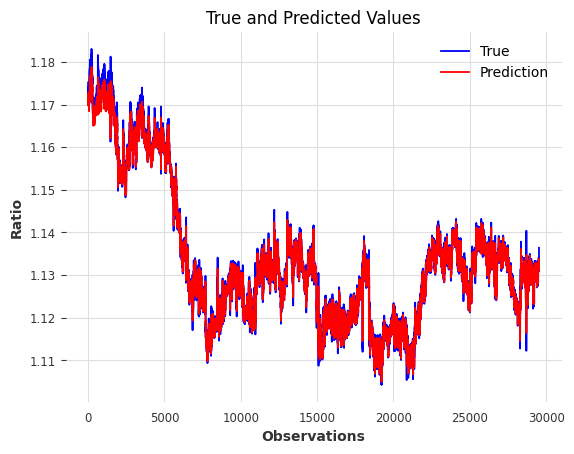

Prediction Error: {'RMSE': 0.0012247678345850873, 'MASE': 1.597256814279808, 'MAPE': 0.0748957136993775, 'sMAPE': 0.07487208474420279}


_____Total Profits_____
Total Profits - pure forcasting strategy = [71.72877663273908, 57.8418837213776, 31.28875887924383, 9.15500030185688]
Best Trade Threshold - pure forcasting strategy = 0
Total Profits - mean reversion strategy = [74.01079033448565, 76.77311121016113, 76.83536968148094, 36.08231514481986]
Best Trade Threshold - mean reversion strategy = 0.0005
Total Profits - hybrid strategy = [65.57747770718665, 48.39227937953648, 28.240505122627212, 6.74025248360402]
Best Trade Threshold - hybrid strategy = 0
Total Profits - ground truth strategy = [281.63515120033566, 283.5262851228774, 282.62592099350684, 161.13954491803875]
Best Trade Threshold - ground truth strategy = 0.00025


_____Profits per Trade_____
Profits per Trade - pure forcasting strategy = [0.0024291782928995897, 0.0037854635943309948, 0.004488417569824104, 0.00337324992699221

In [11]:
# Initialize a DataProcessor instance to preprocess and manage the dataset.
dataProcessor = DataProcessor()

# Create a Temporal Convolutional Network (TCN).
model_tcn = create_model("tcn")

# Instantiate a FinancialForecastingModel with the TCN and DataProcessor. This model
# will be used for preparing the data, training, and making predictions.
predictor = FinancialForecastingModel(model_tcn, dataProcessor)

# Split the dataset into training, validation, and test series and then scale the data appropriately.
train_series, valid_series, test_series = predictor.split_and_scale_data_darts()

# Train the model using the training and validation series.
predictor.train_darts(train_series, valid_series)

# Generate predictions for the test series and retrieve the actual values for comparison.
predicted_values = predictor.generate_predictions_darts(test_series)
true_values = predictor.get_true_values_darts(test_series)

# Plot the actual and predicted values using matplotlib to visualize the model's performance.
plt.plot(true_values, color = 'blue', label = 'True')
plt.plot(predicted_values, color = 'red', label = 'Prediction')
plt.title('True and Predicted Values')
plt.xlabel('Observations')
plt.ylabel('Ratio')
plt.legend()
plt.show()

# Determine the size of the test dataset to simulate trading strategies.
test_size = len(true_values)

# Calculate the prediction error using the actual and predicted values.
prediction_error = predictor.calculate_prediction_error(predicted_values, true_values)
print(f"Prediction Error: {prediction_error}")
print (f"\n")

# Retrieve the numerator and denominator prices for the test dataset from the DataProcessor.
numerator_prices, denominator_prices = dataProcessor.get_test_columns(test_size)

# Simulate trading strategies using the actual and predicted values, along with the numerator and
# denominator prices, to assess the financial performance of the forecasting model.
simulate_trading_with_strategies(true_values, predicted_values, numerator_prices, denominator_prices)

#Sample Application of Bidirectional LSTM (BiLSTM) for Advanced Financial Forecasting


Epoch 1/50
37/37 [==============================] - 14s 104ms/step - loss: 0.0107 - val_loss: 0.0133
Epoch 2/50
37/37 [==============================] - 2s 64ms/step - loss: 0.0012 - val_loss: 0.0114
Epoch 3/50
37/37 [==============================] - 2s 64ms/step - loss: 0.0010 - val_loss: 0.0113
Epoch 4/50
37/37 [==============================] - 2s 65ms/step - loss: 9.9906e-04 - val_loss: 0.0102
Epoch 5/50
37/37 [==============================] - 2s 65ms/step - loss: 9.6769e-04 - val_loss: 0.0109
Epoch 6/50
37/37 [==============================] - 2s 65ms/step - loss: 9.5751e-04 - val_loss: 0.0120
Epoch 7/50
37/37 [==============================] - 2s 65ms/step - loss: 9.1131e-04 - val_loss: 0.0092
Epoch 8/50
37/37 [==============================] - 2s 65ms/step - loss: 9.9683e-04 - val_loss: 0.0128
Epoch 9/50
37/37 [==============================] - 2s 65ms/step - loss: 7.9667e-04 - val_loss: 0.0129
Epoch 10/50
37/37 [==============================] - 2s 65ms/step - loss: 7.7436e-0

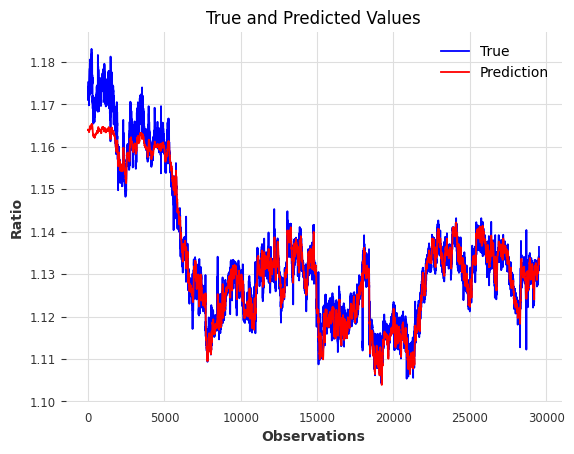

Prediction Error: {'RMSE': 0.0030462822184128668, 'MASE': 21.77838474854085, 'MAPE': 0.16914609827884158, 'sMAPE': 0.16888955424036325}


_____Total Profits_____
Total Profits - pure forcasting strategy = [59.828020792059064, 58.283875649897375, 56.688889178590436, 49.6356706927296]
Best Trade Threshold - pure forcasting strategy = 0
Total Profits - mean reversion strategy = [74.01079033448565, 76.77311121016113, 76.83536968148094, 36.08231514481986]
Best Trade Threshold - mean reversion strategy = 0.0005
Total Profits - hybrid strategy = [60.43823877524338, 57.59326796870589, 53.27288041224321, 23.67075271203729]
Best Trade Threshold - hybrid strategy = 0
Total Profits - ground truth strategy = [281.63515120033566, 283.5262851228774, 282.62592099350684, 161.13954491803875]
Best Trade Threshold - ground truth strategy = 0.00025


_____Profits per Trade_____
Profits per Trade - pure forcasting strategy = [0.00202614538038672, 0.002238501964508099, 0.002500612667780787, 0.003049810795252

In [12]:
# Initialize a DataProcessor instance to preprocess and manage the dataset.
dataProcessor = DataProcessor()

# Create an BiLSTM model.
model_bilstm = create_model("bilstm")

# Instantiate a FinancialForecastingModel with the BiLSTM and DataProcessor. This model
# will be used for preparing the data, training, and making predictions.
predictor = FinancialForecastingModel(model_bilstm, dataProcessor)

# Split the dataset into training, validation, and test series and then scale the data appropriately.
data = predictor.split_and_scale_data_tf()

# Train the model using the training and validation series.
predictor.train_tf(data['x_train'], data['y_train'], data['x_valid'], data['y_valid'])

# Generate predictions for the test series and retrieve the actual values for comparison.
output = predictor.generate_predictions_tf(data['x_test'], data['y_test'])
true_values = data['y_test']

predicted_values = [item[0] for item in output['predicted_values']]
true_values = [item[0] for item in output['true_values']]

# Plot the actual and predicted values using matplotlib to visualize the model's performance.
plt.plot(true_values, color = 'blue', label = 'True')
plt.plot(predicted_values, color = 'red', label = 'Prediction')
plt.title('True and Predicted Values')
plt.xlabel('Observations')
plt.ylabel('Ratio')
plt.legend()
plt.show()

# Determine the size of the test dataset to simulate trading strategies.
test_size = len(true_values)

# Calculate the prediction error using the actual and predicted values.
prediction_error = predictor.calculate_prediction_error(predicted_values, true_values)
print(f"Prediction Error: {prediction_error}")
print (f"\n")

# Retrieve the numerator and denominator prices for the test dataset from the DataProcessor.
numerator_prices, denominator_prices = dataProcessor.get_test_columns(test_size)

# Simulate trading strategies using the actual and predicted values, along with the numerator and
# denominator prices, to assess the financial performance of the forecasting model.
simulate_trading_with_strategies(true_values, predicted_values, numerator_prices, denominator_prices)

#Contributors:

1.   Sohail Hodarkar: sph8686@nyu.edu
2.   Beakal Lemeneh: beakalmulusew@gmail.com
